In [1]:
import pyspark
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Transformação das colunas

In [2]:
df = pd.read_csv('laptops.csv', sep = ',', header=0, encoding='ISO-8859-1', index_col=0)

df['Ram'] = df['Ram'].apply(lambda a: a[0:-2])

df['Weight'] = df['Weight'].apply(lambda a: a[0:-2])

df.to_csv('laptops-transform.csv')

In [3]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


In [4]:
df['Gpu'].value_counts()

Intel HD Graphics 620      281
Intel HD Graphics 520      185
Intel UHD Graphics 620      68
Nvidia GeForce GTX 1050     66
Nvidia GeForce GTX 1060     48
                          ... 
Nvidia GTX 980 SLI           1
Intel HD Graphics 530        1
AMD Radeon R7                1
AMD R4 Graphics              1
AMD Radeon Pro 560           1
Name: Gpu, Length: 110, dtype: int64

In [5]:
df['TypeName'].value_counts()

Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: TypeName, dtype: int64

In [6]:
df['OpSys'].value_counts()

Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: OpSys, dtype: int64

# SPARK

## Carregar dados

In [7]:
spark = SparkSession.builder.getOrCreate()

In [8]:
data = spark.read.csv('laptops-transform.csv', header=True, inferSchema=True).cache()

In [9]:
print('Total Records = {}'.format(data.count()))

Total Records = 1303


In [10]:
data.show()

+---+-------+-----------------+---------+------+--------------------+--------------------+---+-------------------+--------------------+----------+------+-----------+
|_c0|Company|          Product| TypeName|Inches|    ScreenResolution|                 Cpu|Ram|             Memory|                 Gpu|     OpSys|Weight|Price_euros|
+---+-------+-----------------+---------+------+--------------------+--------------------+---+-------------------+--------------------+----------+------+-----------+
|  1|  Apple|      MacBook Pro|Ultrabook|  13.3|IPS Panel Retina ...|Intel Core i5 2.3GHz|  8|          128GB SSD|Intel Iris Plus G...|     macOS|  1.37|    1339.69|
|  2|  Apple|      Macbook Air|Ultrabook|  13.3|            1440x900|Intel Core i5 1.8GHz|  8|128GB Flash Storage|Intel HD Graphics...|     macOS|  1.34|     898.94|
|  3|     HP|           250 G6| Notebook|  15.6|   Full HD 1920x1080|Intel Core i5 720...|  8|          256GB SSD|Intel HD Graphics...|     No OS|  1.86|      575.0|
|  4

# SPARK SQL

In [11]:
data.registerTempTable("laptops")

In [12]:
spark.sql('''
    SELECT Company, count(*) as `# Modelos`, avg(Price_euros) as `Preco Médio`,
    min(Price_euros) as `Preco Mínimo`, max(Price_euros) as `Preco Máximo`,
    avg(Inches) as `Tela média`, avg(`Weight`), avg(Ram)
    from laptops
    GROUP BY Company
    ''').show()

+---------+---------+------------------+------------+------------+------------------+------------------+------------------+
|  Company|# Modelos|       Preco Médio|Preco Mínimo|Preco Máximo|        Tela média|       avg(Weight)|          avg(Ram)|
+---------+---------+------------------+------------+------------+------------------+------------------+------------------+
|    Razer|        7|3346.1428571428573|      1029.0|      6099.0|14.514285714285714|2.1957142857142857|19.428571428571427|
|  Fujitsu|        3|             729.0|       649.0|       799.0|              15.6|2.2333333333333334| 6.666666666666667|
|   Huawei|        2|            1424.0|      1349.0|      1499.0|              13.0|              1.05|               8.0|
|   Xiaomi|        4|         1133.4625|       935.0|     1399.95|             14.45|              1.62|              10.0|
|       HP|      274| 1067.774854014598|       209.0|      4389.0|14.943065693430636|1.9113138686131397| 6.912408759124087|
|     De

# SPARK MLIB

## Transformar Dummies

In [13]:
stringIndexer = StringIndexer(inputCol="TypeName", outputCol="categoryIndex")

In [14]:
model = stringIndexer.fit(data)
indexed = model.transform(data)
encoder = OneHotEncoder(inputCol="categoryIndex", outputCol="categoryVec")
encoded = encoder.transform(indexed)

## Transformar em Vetor

In [15]:
assembler = VectorAssembler(inputCols=['Inches', 'Ram', 'Weight', 'categoryVec'],outputCol="features")
assembled = assembler.transform(encoded)

## Separar Teste Treinamento

In [16]:
train, test = assembled.randomSplit([0.7, 0.3])

## Regressão Linear

### Criar Modelo

In [17]:
algo = LinearRegression(featuresCol="features", labelCol="Price_euros")

### Treinar modelo

In [18]:
model = algo.fit(train)

evaluation_summary = model.evaluate(test)

### MAE

In [19]:
evaluation_summary.meanAbsoluteError

288.06002905893513

### RMSE

In [20]:
evaluation_summary.rootMeanSquaredError

391.63146291548696

### R2

In [21]:
evaluation_summary.r2

0.6417794897542859

In [22]:
trainingSummary = model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 1
objectiveHistory: [0.0]
+-------------------+
|          residuals|
+-------------------+
|-122.16871007297004|
| -560.2083861152821|
|-300.63153938010703|
|  444.9407750833443|
|  341.7412899270298|
| 28.488507379529437|
| -300.4483861152821|
| -602.7075215718451|
| -686.0975171280725|
|  347.4607750833443|
|-208.09305966954116|
|  56.69128992702986|
| -161.3485442339031|
| -407.3485442339031|
|-469.30709028453066|
| -84.69136973779288|
|-196.09181809332767|
|-162.38633541587035|
|  27.00333560091974|
| -298.9952413274692|
+-------------------+
only showing top 20 rows

RMSE: 412.618287
r2: 0.669006


### Previsões

In [23]:
predictions = model.transform(test)

# Resultados para Dataframe
p = predictions.select(['Price_euros','prediction']).toPandas()

### Plotar resultados

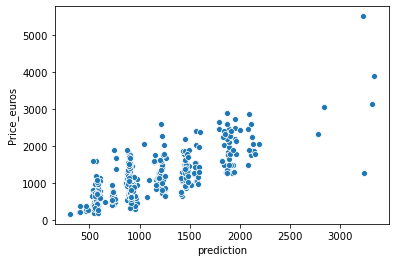

In [24]:
sns.scatterplot(x=p['prediction'], y=p['Price_euros'])
plt.show()

In [25]:
print("Coefficients: %s" % str(model.coefficients))

Coefficients: [-37.914776124530434,83.58915550258142,90.34413192292966,169.6615050327693,431.3015393153151,712.9533152814479,483.7022484474279,1371.5570393379717]


## Decision Trees

In [26]:
# Modificar nome da Price_euros para Labels
assembled_labels = assembled.withColumnRenamed("Price_euros","label")

# Separar teste e treinamento
(trainingData, testData) = assembled_labels.randomSplit([0.7, 0.3])

Root Mean Squared Error (RMSE) on test data = 347.412


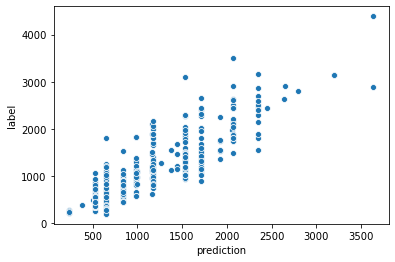

In [27]:
# Criar modelo
dt = DecisionTreeRegressor(featuresCol="features")

# Treinar modelo
model = dt.fit(assembled_labels)

# Fazer previsores
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Separar previsões
p = predictions.select(['label', 'prediction']).toPandas()

# Plotar previsões
sns.scatterplot(x=p['prediction'], y=p['label'])
plt.show()

## Random Forest

Root Mean Squared Error (RMSE) on test data = 366.173


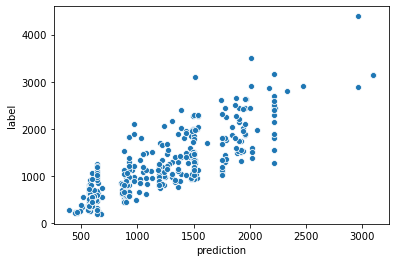

In [28]:
# Criar modelo
model_base = RandomForestRegressor(featuresCol="features")

# Treinar modelo
model = model_base.fit(assembled_labels)

# Fazer previsores
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Separar previsões
p = predictions.select(['label', 'prediction']).toPandas()

# Plotar previsões
sns.scatterplot(x=p['prediction'], y=p['label'])
plt.show()

## Gradient Boosting

Root Mean Squared Error (RMSE) on test data = 285.214


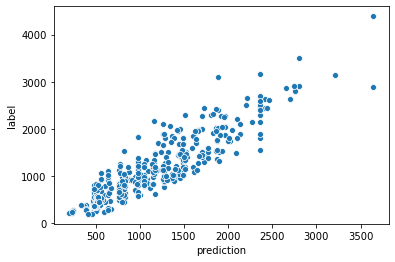

In [29]:
# Criar modelo
model_base = GBTRegressor(featuresCol="features")

# Treinar modelo
model = model_base.fit(assembled_labels)

# Fazer previsores
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Separar previsões
p = predictions.select(['label', 'prediction']).toPandas()

# Plotar previsões
sns.scatterplot(x=p['prediction'], y=p['label'])
plt.show()

### Scaling

In [30]:
# Selecionar variaveis para features
assembler = VectorAssembler(inputCols=['Inches', 'Ram', 'Weight', 'Price_euros'],outputCol="features")
all_num_var = assembler.transform(encoded)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

scalerModel = scaler.fit(all_num_var)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(all_num_var)

## PCA

In [31]:
pca = PCAml(k=2, inputCol="scaledFeatures", outputCol="pca")
model = pca.fit(scaledData)
transformed = model.transform(scaledData)

In [32]:
pca_df = transformed.select('pca').toPandas()

In [33]:
# Passar dimensões para vetores
dim_a = pca_df['pca'].apply(lambda a: a[0])
dim_b = pca_df['pca'].apply(lambda a: a[1])

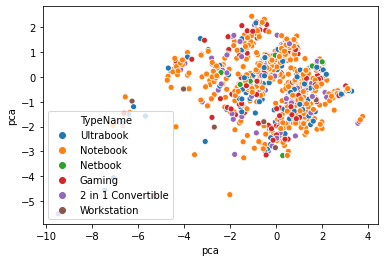

In [34]:
sns.scatterplot(dim_a, dim_b, hue=df['TypeName'])

### Outliers

Possuem muita memória em SSD

In [35]:
df[(dim_b < -4).values]

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
200,Razer,Blade Pro,Gaming,17.3,4K Ultra HD / Touchscreen 3840x2160,Intel Core i7 7820HK 2.9GHz,32,1TB SSD,Nvidia GeForce GTX 1080,Windows 10,3.49,6099.0
498,Toshiba,Portege X30-D-10L,Ultrabook,13.3,Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,32,512GB SSD,Intel HD Graphics 620,Windows 10,1.05,2799.0
617,Lenovo,Thinkpad P51,Notebook,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Xeon E3-1535M v6 3.1GHz,32,1TB SSD,Nvidia Quadro M2200M,Windows 10,2.5,4899.0
839,Razer,Blade Pro,Gaming,17.3,4K Ultra HD / Touchscreen 3840x2160,Intel Core i7 7820HK 2.9GHz,32,512GB SSD,Nvidia GeForce GTX 1080,Windows 10,3.49,5499.0
1081,Asus,ROG G701VO,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 6820HK 2.7GHz,64,1TB SSD,Nvidia GeForce GTX 980,Windows 10,3.58,3975.0


## Clusterização

Silhouette with squared euclidean distance = 0.7320811851409378
Cluster Centers: 
[  14.68905579    9.93991416    1.89756652 1463.98403433]
[ 15.11316527   5.90196078   2.0279888  637.90477591]
[1.57032520e+01 1.68780488e+01 2.63593496e+00 2.65433805e+03]


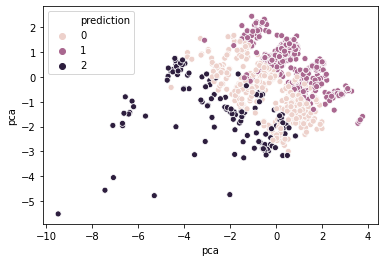

In [36]:
# Treinar modelo
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(all_num_var)

# Fazer previsões
predictions = model.transform(all_num_var)

# Avaliar cluster
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

cluster = predictions.select('prediction').toPandas()['prediction']

sns.scatterplot(dim_a, dim_b, hue=cluster)
plt.show()